In [2]:
import sys
import os
import pandas as pd
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), 'src')))

%load_ext autoreload
%autoreload 2
from utils.ArticlesParser import process_articles_directory
from utils.Graph import *
from utils.Preprocessing import *
from utils.Visualization import *
from sentence_transformers import SentenceTransformer, util

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


c:\Users\antoi\anaconda3\envs\ada\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [3]:
data_path = os.path.abspath(os.path.join(os.getcwd(), 'data'))
articles_path = os.path.join(data_path, 'plaintext_articles')

# change_name_files_plaintext_articles(data_path)

parsed_articles = process_articles_directory(articles_path)
df = pd.DataFrame(parsed_articles, columns=['Article_Title', 'Related_Subjects', 'Description'])
print(f"There are : {len(df)} articles")
df.head()

There are : 4598 articles


,Article_Title,Related_Subjects,Description
0,Áedán_mac_Gabráin,[British History 1500 and before (including Ro...,"Áedán mac Gabráin was king of Dál Riata, a kin..."
1,Åland,"[Countries, European Countries]","Åland (pronounced IPA: ['oːland] in Swedish), ..."
2,Édouard_Manet,[Artists],"Édouard Manet ( January 23, 1832 – April 30, 1..."
3,Éire,"[Countries, European Countries]",Éire ( pronounced [ˈeːrʲə]) is the Irish name ...
4,Óengus_I_of_the_Picts,[British History 1500 and before (including Ro...,"Óengus, son of Fergus ( Hypothetical Pictish f..."


In [4]:
model = SentenceTransformer("all-MiniLM-L6-v2")

In [5]:
# This needs to calculate the embeddings for each article and description, takes time.
embedded_articles = articles_to_embeddings(parsed_articles, model)

In [6]:
for title in embedded_articles:
    score = util.dot_score(*embedded_articles[title])
    if score < 0.2:
        print(f"{title} score: {float(score):.4f}")

Amur score: 0.1967
Cheers score: 0.1901
Lottie_Dod score: 0.1621


In [7]:
# Both are science fiction writers. Using only their names, the cosine similarity
# is low. But with more context, their cosine similarity is high. They are indeed
# bi-directionally linked as they had influence in each other's lives.
print("John Campbell and Isaac Asimov comparison")
john_embedding, john_desc_embedding = embedded_articles["John_W._Campbell"]
isaac_embedding, isaac_desc_embedding = embedded_articles["Isaac_Asimov"]
print(f"Cosine similarity between article names: {float(util.dot_score(john_embedding, isaac_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(john_desc_embedding, isaac_desc_embedding)):.4f}")

# It can also help to disambiguate: a limerick is a form of poetry, so these two
# should be linked if we only take into account the article name. But the Limerick
# article actually talks about the city in Ireland, not the form of poetry.
print("\nLimerick and Poetry comparison")
limerick_embedding, limerick_desc_embedding = embedded_articles["Limerick"]
poetry_embedding, poetry_desc_embedding = embedded_articles["Poetry"]
print(f"Cosine similarity between article names: {float(util.dot_score(limerick_embedding, poetry_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(limerick_desc_embedding, poetry_desc_embedding)):.4f}")

# In the case where the articles should be linked but the description isn't similar
# like winter and summer which are opposing, the description cosine similarity is
# lower, but closer to the article name similarity than in the case of disambiguation.
print("\nWinter and Summer comparison")
winter_embedding, winter_desc_embedding = embedded_articles["Winter"]
summer_embedding, summer_desc_embedding = embedded_articles["Summer"]
print(f"Cosine similarity between article names: {float(util.dot_score(winter_embedding, summer_embedding)):.4f}")
print(f"Cosine similarity between descriptions: {float(util.dot_score(winter_desc_embedding, summer_desc_embedding)):.4f}")

John Campbell and Isaac Asimov comparison
Cosine similarity between article names: 0.2334
Cosine similarity between descriptions: 0.5171

Limerick and Poetry comparison
Cosine similarity between article names: 0.5433
Cosine similarity between descriptions: 0.1685

Winter and Summer comparison
Cosine similarity between article names: 0.6008
Cosine similarity between descriptions: 0.4943


### Discussion
Intuitively, articles should be linked if the cosine similarity between descriptions is higher than a certain threshold, while being close to the article names cosine similarity. But it is easier to let a neural network determine the weights while passing on both the article names and descriptions embeddings as variables for each node.

In [8]:
df_links = preprocessing_links(data_path)
df_links.head()

,Articles,Links
0,10th_century,"[11th_century, 9th_century, Algeria, Beer, Bla..."
1,11th_century,"[10th_century, 12th_century, 13th_century, 14t..."
2,12th_century,"[10th_century, 11th_century, 13th_century, 14t..."
3,13th_century,"[12th_century, 14th_century, Angola, Arabic_la..."
4,14th_century,"[13th_century, 15th_century, Abacus, Aztec, Bl..."


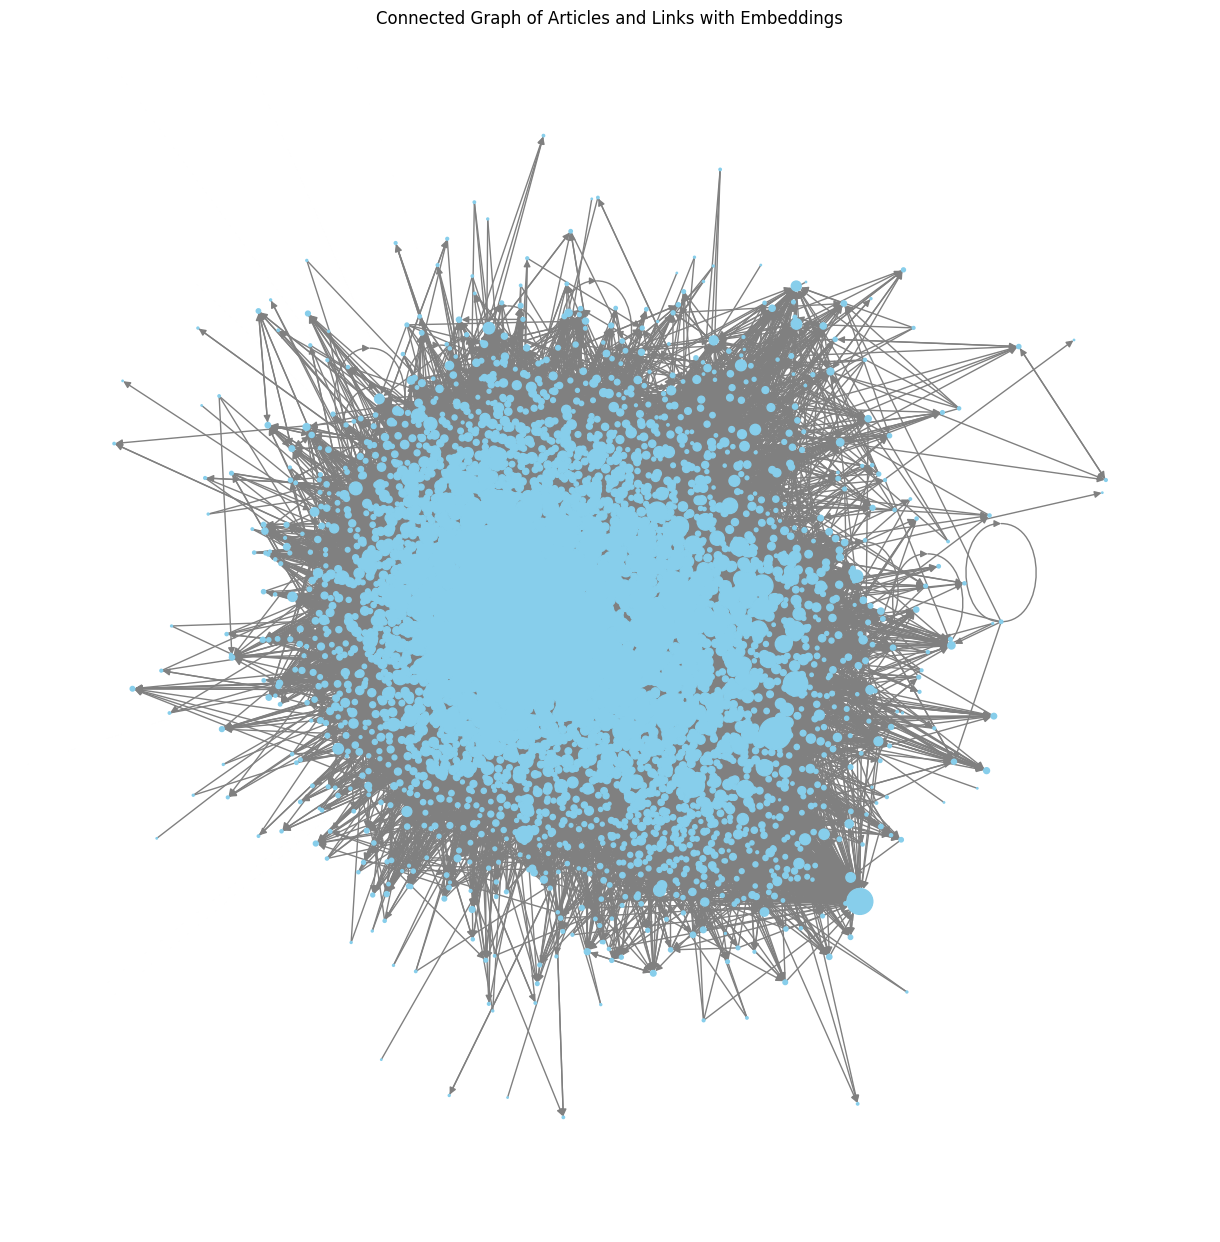

In [9]:
G=create_graph(embedded_articles, df_links)
visualize_graph(G)

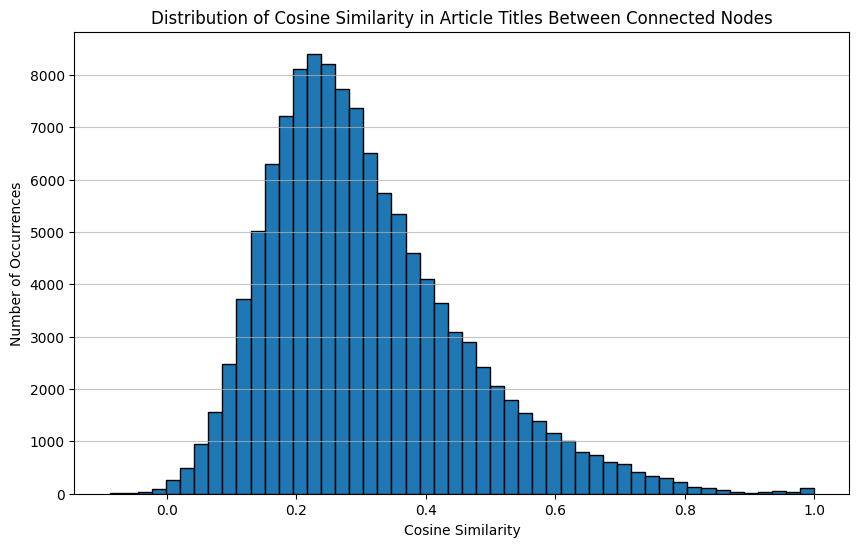

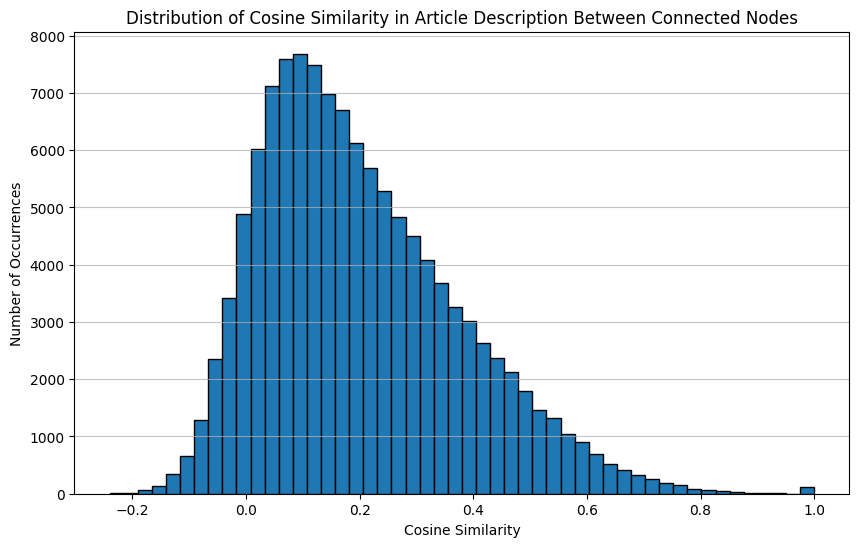

In [10]:
visualize_connected_node_similarity_distributions(G)

## Description

Now to compare these distribution with the cosine similarities of article titles and descriptions between unconnected nodes, we will take a representative sample of the articles and calculate their cosine similarities.

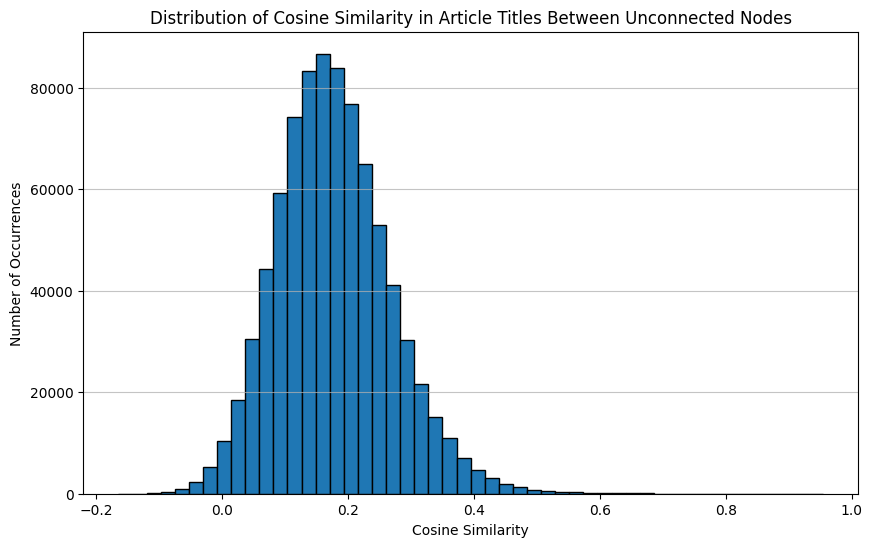

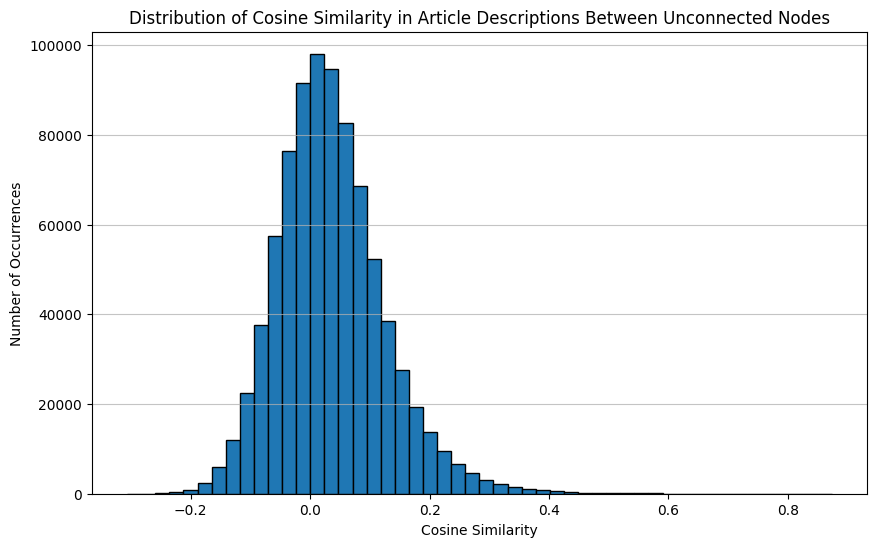

In [11]:
similarities = visualize_unconnected_node_similarity_distributions(G, len(G.nodes)//5)

In [12]:
for s in similarities:
    if s['title_similarity'] > 0.7 and s['description_similarity'] > 0.6:
        print(s['source'] + ' ' + s['target'])

4-6-0 6-2-0
Edward_VI_of_England Edward_III_of_England
Henry_VII_of_England Henry_IV_of_England
6-2-0 4-6-0
Corn_oil Palm_oil
Henry_IV_of_England Henry_VII_of_England
Henry_IV_of_England Henry_I_of_England
Henry_I_of_England Henry_IV_of_England
Medieval_literature Literature
Comet_Hyakutake Comet_Halley
Rubidium Iridium
Coconut_oil Palm_oil
Henry_I_of_England Henry_VII_of_England
Hurricane_Charley Hurricane_Lenny
Palm_oil Coconut_oil
Hurricane_Lenny Hurricane_Charley
Literature Medieval_literature
Henry_VII_of_England Henry_I_of_England
Richard_I_of_England Richard_II_of_England
Palm_oil Corn_oil
Richard_II_of_England Richard_I_of_England
Edward_III_of_England Edward_VI_of_England
Iridium Rubidium
Comet_Halley Comet_Hyakutake


Remark : 
-javais la flemme de faire des.py pour le moment je les ferai apres eu votre feedback
-on fait rien avec les catégories des articles car on a deja le context plus précis, mais faut en parler dans le rapport. 
Question : 
-est ce quon dit qq chose sur les liens reciproques (A<->B) ?
-est ce quon dit quil faudrait faire des test statistiques entre les features pour voir si il y a des redondances, avant de les mettre dans le modele  je veux dire ?
-est ce quon parle à un moment de la longueur des articles vs du nombre de liens présents ?

## GRAPH STATISTICAL ANALYSIS

To gain a better understanding of the data, some basics but important characteristics of the graph are computed/displayed. This will help guide us in selecting the most appropriate approach for the next steps.

In [ ]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

import networkx as nx

#Make sure to have a connected graph without isolated nodes

#Here we create subgraphs for each connected component
components = list(nx.connected_components(G.to_undirected()))
print(f"Number of connected components: {len(components)}")
subgraphs = [G.to_undirected().subgraph(component).copy() for component in components]

for i in range(len(subgraphs)):
    subgraph_1 = subgraphs[i]
    print(f"Number of nodes in subgraph {i}: {subgraph_1.number_of_nodes()}, {subgraph_1.nodes()}")
    print(f"Number of edges in subgraph {i}: {subgraph_1.number_of_edges()}")


Number of connected components: 10
Number of nodes in subgraph 0: 4589, ['Áedán_mac_Gabráin', 'Åland', 'Édouard_Manet', 'Éire', 'Óengus_I_of_the_Picts', '€2_commemorative_coins', '10th_century', '11th_century', '12th_century', '13th_century', '14th_century', '15th_century', '15th_Marine_Expeditionary_Unit', '16th_century', '16_Cygni', '16_Cygni_Bb', '1755_Lisbon_earthquake', '17th_century', '1896_Summer_Olympics', '18th_century', '1928_Okeechobee_Hurricane', '1973_oil_crisis', '1980_eruption_of_Mount_St._Helens', '1997_Pacific_hurricane_season', '19th_century', '1st_century', '1st_century_BC', '1_Ceres', '2-6-0', '2-8-0', '2003_Atlantic_hurricane_season', '2004_Atlantic_hurricane_season', '2004_Indian_Ocean_earthquake', '2005_Atlantic_hurricane_season', '2005_Hertfordshire_Oil_Storage_Terminal_fire', '2005_Kashmir_earthquake', '2005_Lake_Tanganyika_earthquake', '2005_Sumatra_earthquake', '20th_century', '21st_century', '2nd_century', '3rd_century', '3_Juno', '4-2-0', '4-4-0', '4-6-0', 

Except subgraphs[0], the rest correpond to isolated node, so we can get rid of them in the rest of the analysis

In [ ]:
def analyze_graph_statistics(G):
    """
    In this function, some characteristics of the graph are computed 
    """
    # Number of nodes and edges
    num_nodes = G.number_of_nodes()
    num_edges = G.number_of_edges()

    #average degree
    degrees = [deg for _,deg in G.degree()]
    average_deg=np.mean(degrees)

    # Degree distribution
    plt.figure()
    plt.hist(degrees,bins=40,log=True,edgecolor='black')
    plt.xlabel("Nodes Degrees")
    plt.ylabel("Occurances")
    plt.title("Degree Distribution")
    plt.show()
    # Network density
    density = nx.density(G)

    # Clustering coefficient
    clustering_coeff = nx.average_clustering(G)
    #Average shortest path length
    avg_path_length = nx.average_shortest_path_length(G)

    #Print results
    print(f"Number of nodes: {num_nodes}")
    print(f"Number of edges: {num_edges}")
    print(f"Average degree: {average_deg:.2f}")
    print(f"Network density: {density:.4f}")
    print(f"Clustering coefficient: {clustering_coeff:.4f}")
    print(f"Average Shortest path: {avg_path_length:.4f}")


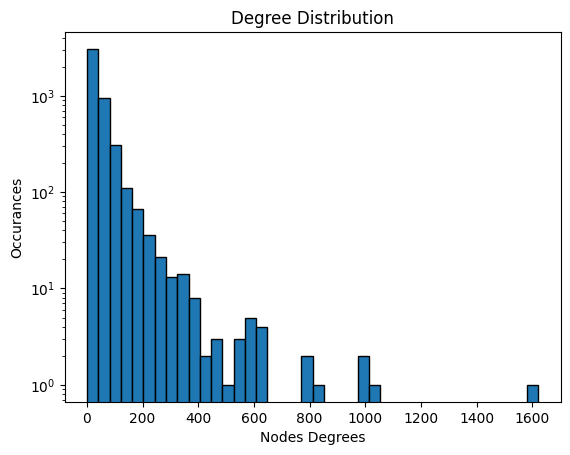

Number of nodes: 4589
Number of edges: 106644
Average degree: 46.48
Network density: 0.0101
Clustering coefficient: 0.2745
Average Shortest path: 2.5253


In [42]:
#subgraphs[0] is fully connected
analyze_graph_statistics(subgraphs[0])

## Results analysis

The graph is medium size and seems well connected, as the number of edges (>100000) is important compared to the number of nodes (~4500), and the average degree is pretty high (46.48).
The distribution of the nodes degrees is a right skewed distribution.
Thought the density is pretty low and indicates potential for discovering new links.
The clustering coefficient indicates that we are more likely to find local clusters.
Finally, it seems that most nodes can be reached from every other node in a small number of steps, as the avergae shortest path is ~2.53.

Thus, the features engineering focus should be on local structure features and short path, but the high connectivity suggests that global features could be important aswell.

## Feature engineering

To train the model, we introduce a set of handcrafted features tailored to the context of link prediction. These features are selected based on the project's aim and the statistical analyses conducted above. They are intended to be the most relevant for achieving effective link creation.

In [ ]:
#Nodes features 

#Calculate Eigen centrality for all node pairs
#There are others ways to compute the centrality btw
centrality = nx.eigenvector_centrality(subgraphs[0])
data = []
for u, v in centrality.items():
    data.append({"Article_1": u, "eigenvector": v})
    
#Get the values in a dataframe
df_eigen = pd.DataFrame(data)
df_eigen.sort_values("eigenvector", ascending=False, inplace=True)

#Links features

#Calculate Jaccard similarity for all node pairs
G_undirected=subgraphs[0].to_undirected()
jaccard_similarities = nx.jaccard_coefficient(G_undirected)
#Get the values in a dataframe
data = []
for u, v, p in jaccard_similarities:
    data.append({"Article_1": u, "Article_2": v, "jaccard_similarity": p})

df_jaccard = pd.DataFrame(data)
df_jaccard.sort_values("jaccard_similarity", ascending=False, inplace=True)

# Calculate Adamic_adar_index similarity for all node pairs
G_undirected=subgraphs[0].to_undirected()
adamic_adar_index = nx.adamic_adar_index(G_undirected)
#Get the values in a dataframe
data = []
for u, v, p in adamic_adar_index:
    data.append({"Article_1": u, "Article_2": v, "adamic_adar_index": p})

df_adamic = pd.DataFrame(data)
df_adamic.sort_values("adamic_adar_index", ascending=False, inplace=True)


In [58]:
df_eigen

,Article_1,eigenvector
4293,United_States,2.068717e-01
1566,France,1.919351e-01
4289,United_Kingdom,1.831108e-01
1431,Europe,1.750011e-01
4143,Time_zone,1.530638e-01
...,...,...
1776,Great_hammerhead,4.240657e-24
1766,Greater_Cane_Rat,4.240657e-24
4052,The_Catcher_in_the_Rye,4.240657e-24
4053,The_Catlins,4.240657e-24


In [59]:
df_jaccard

,Article_1,Article_2,jaccard_similarity
7082143,Eurasian_Bullfinch,Hawfinch,1.0
7222705,Reed_Bunting,Hawfinch,1.0
7079621,Eurasian_Bullfinch,Reed_Bunting,1.0
429204,White's_Tree_Frog,Australian_Green_Tree_Frog,1.0
1113481,Duchenne_muscular_dystrophy,Klinefelter's_syndrome,1.0
...,...,...,...
4619031,Norman_conquest_of_England,David_Hilbert,0.0
4619025,Norman_conquest_of_England,Babe_Ruth,0.0
4619013,Norman_conquest_of_England,Bedbug,0.0
4619012,Norman_conquest_of_England,Mistle_Thrush,0.0


In [60]:
df_adamic

,Article_1,Article_2,adamic_adar_index
8780321,England,United_States,83.407958
5337255,Chordate,Binomial_nomenclature,72.607095
5431642,London,United_States,68.688406
7749721,Scientific_classification,Europe,59.432855
3560009,China,India,54.999616
...,...,...,...
4619031,Norman_conquest_of_England,David_Hilbert,0.000000
4619025,Norman_conquest_of_England,Babe_Ruth,0.000000
4619013,Norman_conquest_of_England,Bedbug,0.000000
4619012,Norman_conquest_of_England,Mistle_Thrush,0.000000


In [ ]:
#Very clever way to label the nodes apparently, might check the function once again beacuse we should not have 
# some "1" for every hash lol
#It is made to capture a more global concept of neighborhood than the ones above

from collections import defaultdict

def weisfeiler_lehman_step(graph, labels):
    """Perform one WL iteration on the graph and return updated labels."""
    new_labels = {}
    for node in graph.nodes():
        # Create a multi-set label combining the node's current label and its neighbors' labels
        neighborhood = [labels[neighbor] for neighbor in graph.neighbors(node)]
        neighborhood.sort()
        new_labels[node] = hash((labels[node], tuple(neighborhood)))
    return new_labels


# Initial labeling: use node degrees as the initial labels
initial_labels = {node: subgraphs[0].degree(node) for node in subgraphs[0].nodes()}

# Perform a few iterations of the WL algorithm
labels = initial_labels
for i in range(2):  #Tunable number
    labels = weisfeiler_lehman_step(subgraphs[0], labels)
    print(f"Iteration {i + 1}: {labels}")

# Collect the label distribution to create a graph-level feature vector
label_distribution = defaultdict(int)
for label in labels.values():
    label_distribution[label] += 1

print("Graph-level feature vector (label distribution):")
print(dict(label_distribution))


Iteration 1: {'Áedán_mac_Gabráin': -7337204403580779906, 'Åland': -481719334709021505, 'Édouard_Manet': 429920254762259787, 'Éire': 7114310688004301643, 'Óengus_I_of_the_Picts': -935314495538364795, '€2_commemorative_coins': 5831979974154143726, '10th_century': -4648591841514400782, '11th_century': 4636081063521331641, '12th_century': 1681522013184631863, '13th_century': 1442695669133427946, '14th_century': 4639937676249686924, '15th_century': 7959526280913688779, '15th_Marine_Expeditionary_Unit': -2000321943082082450, '16th_century': -3883370991306886833, '16_Cygni': -3640850296351419498, '16_Cygni_Bb': 5600090327843935830, '1755_Lisbon_earthquake': 2418704933078120147, '17th_century': 672075348898020712, '1896_Summer_Olympics': -4196110332032562314, '18th_century': -89014988913052191, '1928_Okeechobee_Hurricane': -1527211238795894898, '1973_oil_crisis': -6490828051177503078, '1980_eruption_of_Mount_St._Helens': -7742539707965213426, '1997_Pacific_hurricane_season': -10822770817360772

In [ ]:
#PageRank algorithm, might be useful in our context, it shows how much a page is connected to the others

pr = nx.pagerank(subgraphs[0], alpha=0.9)
df_pagerank = pd.DataFrame(list(pr.items()), columns=['Article', 'PageRank_Score'])
df_pagerank

,Article,PageRank_Score
0,Áedán_mac_Gabráin,0.000068
1,Åland,0.000093
2,Édouard_Manet,0.000104
3,Éire,0.000054
4,Óengus_I_of_the_Picts,0.000064
...,...,...
4584,Zirconium,0.000230
4585,Zoroaster,0.000149
4586,Zuid-Gelders,0.000054
4587,Zulu,0.000121
